In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np    
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import datetime as dt
from tqdm import tqdm
import pandas as pd

In [2]:
ssts = xr.open_dataset('/mnt/c/Users/Bpara/Downloads/sst.mnmean.nc')
ssts = ssts.sel(time=ssts.time.dt.year>1949)
ssts = ssts.sel(time=ssts.time.dt.year<2022)

anomaly_months = [dt.datetime(1954, 9, 1), dt.datetime(1964, 1, 1), dt.datetime(1977, 2, 1), dt.datetime(1988, 8, 1), dt.datetime(2000, 2, 1), 
                dt.datetime(2006, 9, 1), dt.datetime(2012, 8, 1)]

#import sea surface temps from post 1950 via ersst
ssts

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 864, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-11-04

In [3]:
def month_avg(ssts, month):
    return ssts.sel(time=ssts.time.dt.month==month).mean(dim='time')

In [4]:
%%time
#it doesn't like it if I use a list comprehension for this, so good ole for loop & append is gonna have to do it
months_avg = None
ssts.load()
for year in tqdm(range(1950, 2022)):
    for month in range(1, 13):
        temp = ssts.sel(time=ssts.time.dt.month==month).mean(dim='time')
        temp = temp.expand_dims({'time': 1})
        temp = temp.assign_coords({'time': ('time', [dt.datetime(year, month, 1)])})
        if months_avg is not None:
            months_avg = xr.merge([months_avg, temp])
        else:
            months_avg = temp

100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [01:13<00:00,  1.02s/it]

CPU times: user 50.7 s, sys: 8.11 s, total: 58.8 s
Wall time: 1min 14s


In [5]:
months_avg

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 864, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

In [6]:
def month_anomaly_plot(ssts, year_month):
    
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
    im = ax.pcolor(ssts['lon']+180, ssts['lat'], ssts['sst'].sel(time=year_month)-month_avg(ssts, year_month.month)['sst'], 
                   alpha=0.75, cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(im)
    ax.set_title(f'''Sea surface temperature anomaly for {months[year_month.month]}, {year_month.year} \n
compared to 1950-2022 {months[year_month.month]} Average''')

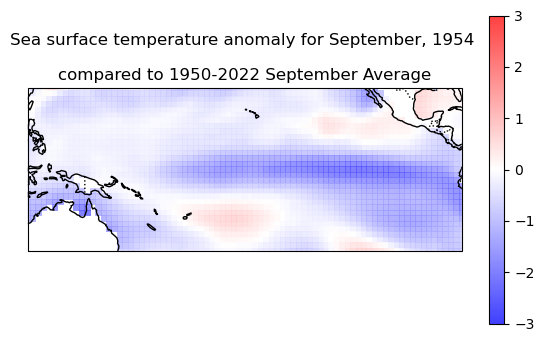

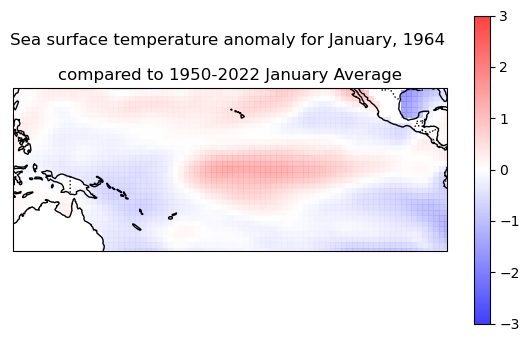

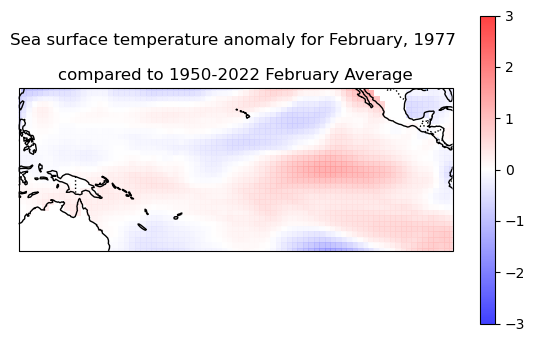

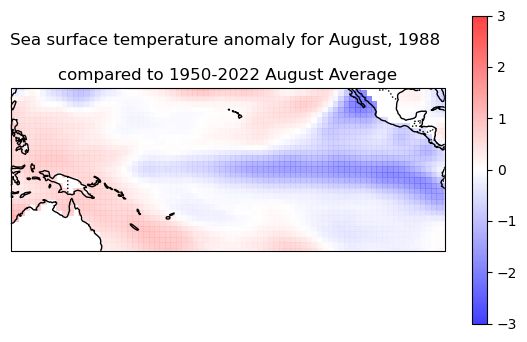

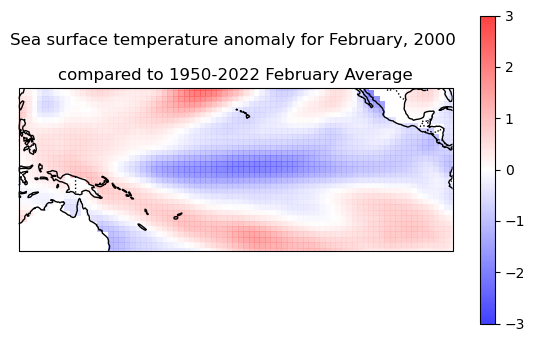

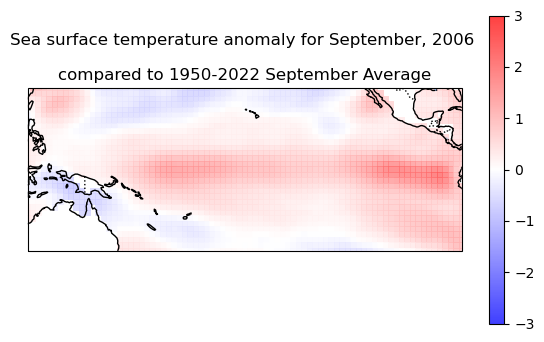

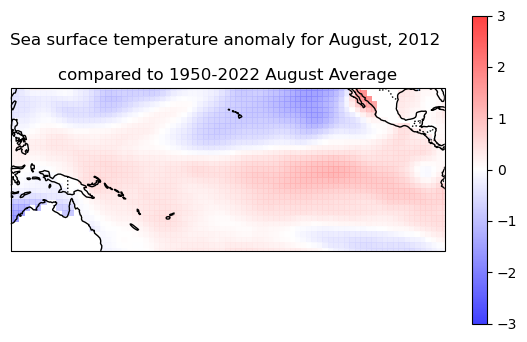

In [7]:
for anomaly in anomaly_months:
    month_anomaly_plot(ssts, anomaly)

In [8]:
mean_anomaly = 0
for anomaly in anomaly_months:
    mean_anomaly+=(ssts['sst'].sel(time=anomaly)-month_avg(ssts, anomaly.month)['sst'])/len(anomaly_months)

Text(0.5, 1.0, 'Average of all 7 low flow event Sea surface temperature \nanomaly')

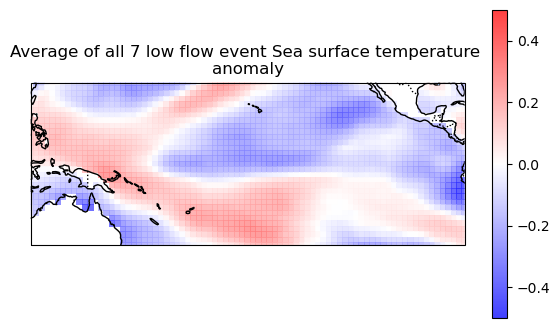

In [9]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(ssts['lon']+180, ssts['lat'], mean_anomaly, alpha=0.75, cmap='bwr', vmin=-0.5, vmax=0.5)
plt.colorbar(im)
ax.set_title('Average of all 7 low flow event Sea surface temperature \nanomaly')

Theory: Each monthly SST anomaly pattern is being drawn from some theoretical distrubition of 2D SST anomaly patterns according to some probability distribution. We have N=72 draws for each month for 852 draws total, so if I draw M=50,000 864-size samples with replacement from each month and calculate the mean and standard deviation of the distribution of SST anomalies, I can find a bootstrapped estimate for the mean monthly anomaly and the standard deviation of said mean monthly anomaly. This assumes the monthly anomaly is being pulled from the same distribution each month however, which might be a point to revisit

In [10]:
def generate_months(num_months, year_min, year_max, month_min, month_max, random_seed=42):
    rng = np.random.default_rng(seed=random_seed)
    years = rng.integers(low=year_min, high=year_max, size=num_months)
    months = rng.integers(low=month_min, high=month_max, size=num_months)
    return [dt.datetime(year, month, 1) for year, month in zip(years, months)]

In [11]:
def bootstrap_ssts(ssts, months_avg, resample_size, num_resamples, lat_min=30, lon_min=120, lat_max=-30, lon_max=280, starting_random_seed=42, 
                   year_min=1950, year_max=2021, month_min=1, month_max=12,):
    
    bootstrap_sample_mean = None
    bootstrap_sample_std = None
    
    for m in tqdm(range(num_resamples)):
        months = generate_months(resample_size, year_min, year_max, month_min, month_max, random_seed=starting_random_seed+m)
        resample_pull = (ssts.sel(time=months, lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)) - 
                         months_avg.sel(time=months, lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)))
        
        resample_mean = resample_pull.mean(dim='time')
        resample_mean = resample_mean.expand_dims({'pull_num': 1})
        resample_mean = resample_mean.assign_coords({'pull_num': ('pull_num', [m])})
        if bootstrap_sample_mean is not None:
            bootstrap_sample_mean = xr.merge([bootstrap_sample_mean, resample_mean])
        else:
            bootstrap_sample_mean = resample_mean
            
        resample_std = resample_pull.std(dim='time')
        resample_std = resample_std.expand_dims({'pull_num': 1})
        resample_std = resample_std.assign_coords({'pull_num': ('pull_num', [m])})
        #Doing this instead of merging at the end because with large num_resamples the kernel dies. The trade-off is it slows as m increases
        if bootstrap_sample_std is not None:
            bootstrap_sample_std = xr.merge([bootstrap_sample_std, resample_std])
        else:
            bootstrap_sample_std = resample_std
            
    return bootstrap_sample_mean, bootstrap_sample_std
        

In [12]:
%%time
mean, std = bootstrap_ssts(ssts, months_avg, 852, 1000, starting_random_seed=0)
mean

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.74it/s]

CPU times: user 1min 36s, sys: 6.23 s, total: 1min 42s
Wall time: 2min 28s


<xarray.Dataset>
Dimensions:    (lat: 31, lon: 81, pull_num: 1000, nbnds: 2)
Coordinates:
  * lat        (lat) float32 30.0 28.0 26.0 24.0 ... -24.0 -26.0 -28.0 -30.0
  * lon        (lon) float32 120.0 122.0 124.0 126.0 ... 274.0 276.0 278.0 280.0
  * pull_num   (pull_num) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (pull_num, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sst        (pull_num, lat, lon) float32 nan 0.0161 ... -0.02615 -0.0311

(array([ 0.,  0.,  2.,  0.,  0.,  0.,  1.,  2.,  2.,  6.,  3.,  9.,  8.,
         8., 13., 19., 24., 29., 35., 36., 43., 43., 53., 46., 50., 56.,
        66., 56., 57., 35., 47., 30., 41., 39., 33., 23., 29., 16., 11.,
         9.,  8.,  7.,  4.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
        -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
        -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
        -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
        -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
         0.00204082,  0.00612245,  0.01020408,  0.01428571,  0.01836735,
         0.02244898,  0.02653061,  0.03061224,  0.03469388,  0.03877551,
         0.04285714,  0.04693878,  0.05102041,  0.05510204,  0.05918367,
         0.06326531,  0.06734694,  0.07142857,  0.0755102 ,  0.07959184,
         0.08367347,  0.0877551 ,  0.09183673,  0.09591837,  0.1

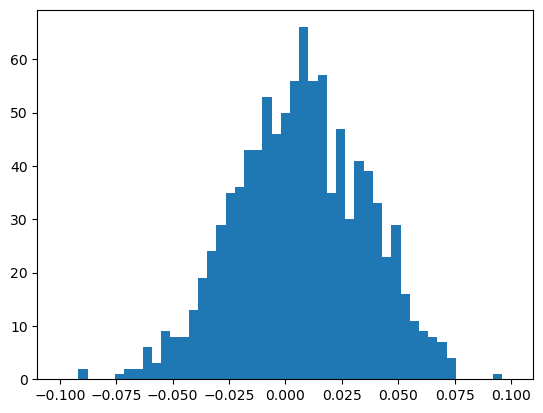

In [13]:
plt.hist(mean.sel(lat=0, lon=180)['sst'], np.linspace(-0.1, 0.1))

Text(0.5, 1.0, 'STD of SST anomaly')

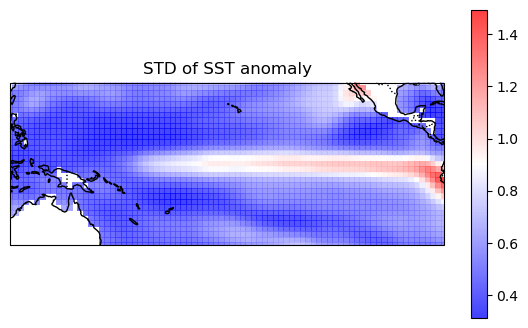

In [26]:
sst_std = std.mean(dim='pull_num')['sst']

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(sst_std['lon']+180, sst_std['lat'], sst_std, alpha=0.75, cmap='bwr')
plt.colorbar(im)
ax.set_title('STD of SST anomaly')

<xarray.DataArray 'sst' (lat: 31, lon: 81)>
array([[       nan, 0.77033067, 0.6924991 , ..., 0.7816426 ,        nan,
        0.5126317 ],
       [       nan, 0.6020833 , 0.5689322 , ..., 0.66404074, 0.61218655,
        0.50965136],
       [0.5174969 , 0.5148492 , 0.5190475 , ..., 0.5130609 , 0.5286868 ,
        0.48224968],
       ...,
       [       nan,        nan,        nan, ..., 0.60054576, 0.61663556,
        0.6339221 ],
       [       nan,        nan,        nan, ..., 0.5603236 , 0.575803  ,
        0.5902677 ],
       [       nan,        nan,        nan, ..., 0.52510935, 0.53448635,
        0.5430364 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 30.0 28.0 26.0 24.0 22.0 ... -24.0 -26.0 -28.0 -30.0
  * lon      (lon) float32 120.0 122.0 124.0 126.0 ... 274.0 276.0 278.0 280.0

Text(0.5, 1.0, 'Average SST anomaly by month')

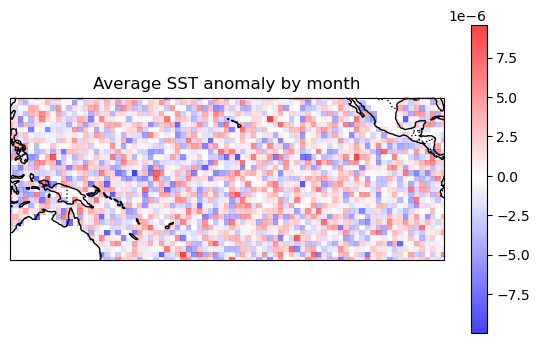

In [15]:
mean_anom = ssts - months_avg
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(ssts['lon']+180, ssts['lat'], mean_anom.sel(time=mean_anom.time.dt.month==12).mean(dim='time')['sst'], 
               alpha=0.75, cmap='bwr')
plt.colorbar(im)
ax.set_title('Average SST anomaly by month')